In [46]:
from tensorflow import keras
from tensorflow.train import Example, Feature, Features
from tensorflow.train import BytesList, FloatList, Int64List
from contextlib import ExitStack
from itertools import chain,cycle

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# Intro:
<p><span style="font-size:18px">This notebook contains the structure of a <strong>DNN </strong>(Deep Neural Network) Model. It <strong>does not contain a CNN</strong> (Convolutional Neural Network).</span></p>

<p><span style="font-size:19px">The accuracy rate </span><span style="font-size:22px"><strong>on the test set</strong></span><span style="font-size:20px"> reached by the model is <strong>90.4%</strong></span></p>

<p><span style="font-size:18px">In this notebook, some state-of-the-art methods like:</span></p>

<ul>
	<li><strong><span style="font-size:18px">Batch Normalization</span></strong></li>
	<li><strong><span style="font-size:18px">Dropout</span></strong></li>
	<li><strong><span style="font-size:18px">Callbacks</span></strong></li>
	<li><strong><span style="font-size:18px">Different Optimizers</span></strong></li>
	<li><strong><span style="font-size:18px">TFRecord Filetype</span></strong></li>
</ul>

<p><span style="font-size:19px">Has been used.</span></p>

<p>&nbsp;</p>


## Fetch The Data

In [47]:
df_train = pd.read_csv("../input/fashionmnist/fashion-mnist_train.csv")
df_test = pd.read_csv("../input/fashionmnist/fashion-mnist_test.csv")
len(df_train), len(df_test)

(60000, 10000)

<p><strong><span style="font-size:18px">Seperate the data into validation, training and test set. Also take the x and y (label) values.</span></strong></p>



In [48]:
X_train, y_train = df_train.iloc[7000:,1:], df_train.iloc[7000:,:1]
X_valid, y_valid = df_train.iloc[:7000,1:], df_train.iloc[:7000,:1]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, :1]

In [49]:
len(X_train), len(X_valid), len(X_test)

(53000, 7000, 10000)

In [50]:
X_train.dtypes, y_train.dtypes

(pixel1      int64
 pixel2      int64
 pixel3      int64
 pixel4      int64
 pixel5      int64
             ...  
 pixel780    int64
 pixel781    int64
 pixel782    int64
 pixel783    int64
 pixel784    int64
 Length: 784, dtype: object,
 label    int64
 dtype: object)

<p><span style="font-size:20px">Every single pixel in our data have <strong>int64</strong> datatype. <strong>Int64 </strong>datatype can hold values between&nbsp;</span><strong>&nbsp;-9,223,372,036,854,775,808 to positive&nbsp;9,223,372,036,854,775,807.&nbsp; </strong><span style="font-size:20px">But our values are just between <u>0 and 255</u>. So, we will convert them to <strong>uint8</strong>, which holds numbers between <strong>0-255</strong>. This is exactly what we want!&nbsp;&nbsp;</span></p>


In [51]:
X_train = X_train.to_numpy(dtype='uint8')
y_train = y_train.to_numpy(dtype='int64')

X_valid = X_valid.to_numpy(dtype='uint8')
y_valid = y_valid.to_numpy(dtype='int64')

X_test = X_test.to_numpy(dtype='uint8')
y_test = y_test.to_numpy(dtype='uint64')

In [52]:
X_train = X_train.reshape(len(X_train), 28,28)
X_valid = X_valid.reshape(len(X_valid), 28,28)
X_test = X_test.reshape(len(X_test), 28,28)

X_train.shape, X_valid.shape, X_test.shape

((53000, 28, 28), (7000, 28, 28), (10000, 28, 28))

In [53]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

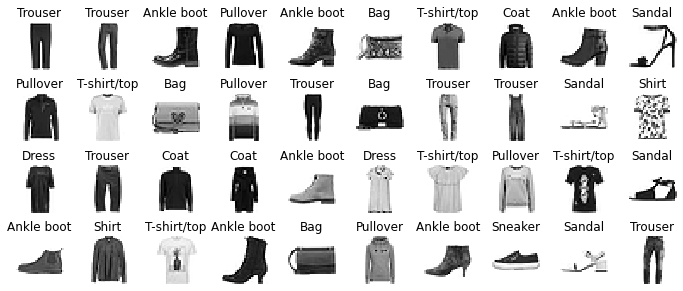

In [54]:
def plot_images(X_train, y_train, n_rows = 4, n_cols = 10):
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[y_train[index][0]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

    # This function is taken from:
    #   https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb
    
plot_images(X_train, y_train)

## Null Check

<p><span style="font-size:20px">To go to the function, visit: <a href="https://github.com/shiny-apricot/My-Machine-Learning-Works/blob/1fd0f319d3384a9d9155de7b6ce0a5048f6645b2/My_Library/plot_null_values.py">shiny-apricot/plot_null_values.py</a></span></p>

<p><span style="font-size:20px">It works both with numpy arrays and dataframes.</span></p>


totalrow= 1 df_count= 3


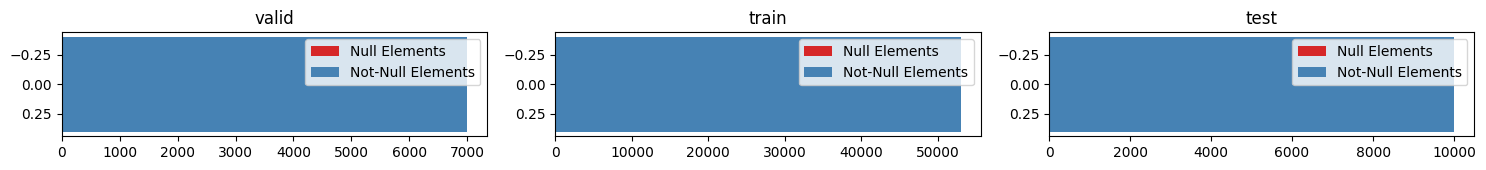

In [83]:
plot_nulls(y_valid, y_train, y_test, height=1.8, titles=['valid','train','test'])

<p><span style="font-size:18px">There is no null values. GREAT!</span></p>


## TFRecord Filetype Conversion

### Why I am Using TFRecord Filetype in This Notebook?

<p><span style="font-size:16px">In fact, using TFRecord in a small dataset like Fashion MNIST has almost no contribution to the performance. However, this notebook is an <strong>example</strong> to show the implementation of TFRecord since it is recommended to use it in large datasets.&nbsp;</span></p>

<p>&nbsp;</p>

### What is TFRecord? 
<p><span style="font-size:16px">Tensorflow Records or TFRecords in short, is the recommended binary file format for high throughput data ingestion, which is optimized for data ingestion for training ML models using Tensorflow.</span></p>

<p>&nbsp;</p>

<p><span style="font-size:16px">If you are working with large datasets, using a <strong>binary file format</strong> for storage of your data can have a significant impact on the performance of your import pipeline and as a consequence on the training time of your model. Binary data <strong>takes up less space on disk</strong>, <strong>takes less time to copy</strong> and <strong>can be read much more efficiently</strong>&nbsp;from disk. This is especially true if your data is stored on spinning disks, due to the much lower read/write performance in comparison with SSDs.</span></p>

<p><span style="font-size:16px">For more information, you can visit: <a href="https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564">https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564</a></span></p>

<p>&nbsp;</p>


<p><span style="font-size:18px">&gt; To begin, let&#39;s convert the numpy arrays into tensorflow 'Tensor' objects first.</span></p>


In [57]:
train_set = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

<p><span style="font-size:18px">&gt; &nbsp;The function below will help us to convert the <strong>Tensors </strong>into <strong>Examples </strong>(some TFRecord objects).</span></p>


In [58]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }
        )
    )

<p><span style="font-size:18px">&gt; You can see below the first element of the <strong>valid_set </strong>after being converted to an Example.<br />
The first key is the image that is converted to binary format and the second key contains is its <strong>label.</strong></span></p>

<p><span style="color:#ffffff"><span style="font-size:18px"><strong><span style="background-color:#c0392b">&nbsp;IMPORTANT:::</span></strong></span></span></p>

<p><span style="font-size:18px">Since we are using uint8 datatype, it is not holding so much space. But if we would first normalize the data and squeeze them between 0 and 1, we may had to use float32 or float64 datatype, which would cause significant increase in the disk usage. So, we will first save the data and normalize it after fetching from the disk.</span></p>


In [59]:
for image, label in valid_set.take(1):
    print(create_example(image,label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\004\000\000\000\000\000>=\025\035\0273\210=\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000X\311\344\341\377s>\211\377\353\336\377\207\000\000\000\000\000\000\000\000\000\000\000\000\000/\374\352\356\340\327\327\345l\264\317\326\340\347\371\376-\000\000\000\000\000\000\000\000\001\000\000\326\336\322\325\340\341\331\334\376\351\333\335\331\337\335\360\376\000\000\001\000\000\000\001\000\000\000\200\355\317\340\340\317\330\326\322\320\323\335\320\333\325\342\323\355\226\000\000\

> The function below **writes** the Example objects into files by **seperating** the data into different parts.

In [60]:
from contextlib import ExitStack

def write_records(name: str, dataset, n_shards=10, directory=""):
    # Create the paths.
    paths= ["{}.tfrecord-{:05d}-of-{:05d}"
            .format(name, index, n_shards) for index in range(n_shards)]
    ## Hold the filenames and save them into csv files...
    path_dataframe = pd.DataFrame(paths)
    path_dataframe.to_csv(name+"_filepaths"+".csv")
    ##
    if not os.path.exists(directory):
        ## Check if the specified directory exists. (default="") 
        os.makedirs(directory)
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(
                                        os.path.join(directory,path))) for path in paths]
        for index, (image,label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image,label)
            writers[shard].write(example.SerializeToString())
        return paths

In [61]:
## Write the Example objects that are gained from tensors into the files in
## specified directories.
write_records("fashion_mnist_train", train_set, directory="TRAIN_TFRECORD")
write_records("fashion_mnist_valid", valid_set, directory="VALID_TFRECORD")
write_records("fashion_mnist_test", test_set, directory="TEST_TFRECORD")

['fashion_mnist_test.tfrecord-00000-of-00010',
 'fashion_mnist_test.tfrecord-00001-of-00010',
 'fashion_mnist_test.tfrecord-00002-of-00010',
 'fashion_mnist_test.tfrecord-00003-of-00010',
 'fashion_mnist_test.tfrecord-00004-of-00010',
 'fashion_mnist_test.tfrecord-00005-of-00010',
 'fashion_mnist_test.tfrecord-00006-of-00010',
 'fashion_mnist_test.tfrecord-00007-of-00010',
 'fashion_mnist_test.tfrecord-00008-of-00010',
 'fashion_mnist_test.tfrecord-00009-of-00010']

> We have written the tfrecord files successfully. Now, it is time to read and turn them into tensorflow Tensor objects. </br>
#### REMEMBER: Using tfrecord files in this notebook is just to show an example about its implementation. Otherwise, it would be sufficient just to take the data from the kaggle datasets.

In [62]:
# Get the filepaths of the .tfrecord files from the .csv lists

train_filepaths = pd.read_csv('fashion_mnist_train_filepaths.csv',
                              header=0, index_col=0).values.tolist()
valid_filepaths = pd.read_csv('fashion_mnist_valid_filepaths.csv',
                              header=0, index_col=0).values.tolist()
test_filepaths = pd.read_csv('fashion_mnist_test_filepaths.csv',
                             header=0, index_col=0).values.tolist()
train_filepaths

[['fashion_mnist_train.tfrecord-00000-of-00010'],
 ['fashion_mnist_train.tfrecord-00001-of-00010'],
 ['fashion_mnist_train.tfrecord-00002-of-00010'],
 ['fashion_mnist_train.tfrecord-00003-of-00010'],
 ['fashion_mnist_train.tfrecord-00004-of-00010'],
 ['fashion_mnist_train.tfrecord-00005-of-00010'],
 ['fashion_mnist_train.tfrecord-00006-of-00010'],
 ['fashion_mnist_train.tfrecord-00007-of-00010'],
 ['fashion_mnist_train.tfrecord-00008-of-00010'],
 ['fashion_mnist_train.tfrecord-00009-of-00010']]

In [63]:

def _parse_image_function(example_proto):
  """
  This function parses image and label objects from a proto.
  Args:
      example_proto (TFRecordDataset): Take the raw tfrecord file.
  Returns:
      Tensor: Return the tfrecord objects as tensor.
  """
    # Create a dictionary describing the features.
  image_feature_description = {
      'image': tf.io.FixedLenFeature([], tf.string, default_value=""),
      'label': tf.io.FixedLenFeature([], tf.int64, default_value=-1),}
    ##
    # Parse the input tf.train.Example proto using the dictionary above.
  example = tf.io.parse_single_example(example_proto, image_feature_description)
  image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    ##
    ## NORMALIZATION
  dividing = tf.constant([255], dtype=tf.uint8)
  image = tf.divide(image,dividing)
    ##
  image = tf.reshape(image, shape=[28,28])
  return image, example["label"]


def get_data(filepaths, directory="", n_threads=2, 
             shuffle_buffer_size=4096, batch_size=4096):
    """
    This function gets the data from the filepaths that we have given.
          Args:
              filepaths (a list of strings): Take the filepaths of
                                              tfrecord files.
              directory (string): The dir that filepaths be in.
              n_threads (int): Number of processor threads that will
                            be used.
              shuffle_buffer_size (int): Size of buffer to shuffle
                                          the data.
              batch_size (int): Max amount of rows that will be fetched
                                from the files at a time.

          Returns:
              Tensors: Return the tfrecord objects as tensor.
    """
    ## JOIN THE DIRECTORY NAME (IF SPECIFIED) WITH THE GIVEN FILEPATHS.
    def join_dir(filepath):
        return os.path.join(directory, filepath[0])
    ##
    filepaths = list(map(join_dir, filepaths))
    dataset = tf.data.Dataset.list_files(filepaths)
    ## num_parallel_reads is for using multiple processor threads to accelerate
    ## the job
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_threads)
    dataset = dataset.map(_parse_image_function, num_parallel_calls=n_threads)
    ## Shuffling might be necessary for the data that are not distributed randomly.
    dataset = dataset.shuffle(shuffle_buffer_size)

    ## IMPORTANT::
    ## Take the data batch by batch. So that, you prevent your RAM to be overfilled.
    dataset = dataset.batch(batch_size)
    ## The 'prefetch' function prepares the next batch just after you call a batch. 
    ##  In this way, you can reach the next batch faster.
    return dataset.prefetch(1)

In [64]:
train_set = get_data(train_filepaths, directory="TRAIN_TFRECORD")
valid_set = get_data(valid_filepaths, directory="VALID_TFRECORD")
test_set = get_data(test_filepaths, directory="TEST_TFRECORD")

In [65]:
for element in train_set.take(1).as_numpy_iterator():
  print('max=',element[0].max(), 'min=',element[0].min())

max= 1.0 min= 0.0


<p><span style="font-size:17px"><strong>As you can see, with the Normalization that we applied in the function &#39;get_data&#39;, our pixel values are stayed between 0 and 1 instead of 0-255.</strong></span></p>


# Model Architecture

<p><span style="font-size:16px">Some concepts that are used in this architecture:</span></p>

<ul>
	<li><span style="font-size:16px">Batch Normalization</span></li>
	<li><span style="font-size:16px">Selu Activation Function and &#39;Lecun Normal&#39; Kernel Initializer</span></li>
	<li><span style="font-size:16px">Dropout</span></li>
</ul>

## Batch Normalization

<ul>
	<li><span style="font-size:16px">In a 2015 paper, Sergey Ioffe and Christian Szegedy proposed a technique called <em>Batch Normalization (BN)</em>. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer.</span></li>
	<br />
	<li><span style="font-size:16px">This operation simply <strong>zero centers</strong> and <strong>normalizes </strong>each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting. In other words, <em>the operation lets the model learn the optimal scale and mean of each of the layer&rsquo;s inputs</em>.</span></li>
	<br />
	<li><span style="font-size:16px">In many cases, if you add a BN layer as the very first layer of your neural network,<strong> you do not need to standardize your training set (e.g., using a StandardScaler); the BN layer will do it for you</strong>&nbsp;(well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature)</span></li>
</ul>

<p style="text-align:right">Aurelion Geron&nbsp;~ Hands on Machine Learning with Scikit Keras and Tensorflow (2019)</p>

## SELU

<h3><span style="font-size:18px"><span style="color:#d35400"><strong>Selu Activation Function and Kernel Initializers</strong></span></span></h3>

<ul>
	<li><span style="font-size:16px">Then, a 2017 paper by G&uuml;nter Klambauer et al. introduced the <strong>Scaled ELU (SELU) </strong>activation function: as its name suggests, it is a scaled variant of the ELU activation function. </span></li>
	<li><span style="font-size:16px">The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will<em><strong> self-normalize</strong></em>: the output of <u><em>each layer will tend to preserve a mean of 0 and standard deviation of 1 during training, which solves the vanishing/exploding gradients problem</em></u>. </span></li>
	<li><span style="font-size:16px">As a result, the SELU activation function often significantly outperforms other activation functions for such neural nets (especially deep ones).</span></li>
</ul>

<p style="text-align:right">Aurelion Geron&nbsp;~ Hands on Machine Learning with Scikit Keras and Tensorflow (2019)</p>

## Dropout

<p><span style="color:#d35400"><strong><span style="font-size:16px">What is Dropout?</span></strong></span></p>

<p><span style="font-size:16px">According to Wikipedia &mdash; *The term &ldquo;dropout&rdquo; refers to dropping out units (both hidden and visible) in a neural network*. Simply put, dropout refers to ignoring units (i.e. neurons) during the training phase of certain set of neurons which is chosen at random. By &ldquo;ignoring&rdquo;, I mean these units are not considered during a particular forward or backward pass.</span></p>

#### Why do we need Dropout?

<ul>
	<li><span style="font-size:16px">The answer to these questions is &ldquo;to prevent over-fitting&rdquo;.</span></li>
	<li><span style="font-size:16px">A fully connected layer occupies most of the parameters, and hence, neurons develop co-dependency amongst each other during training which curbs the individual power of each neuron leading to over-fitting of training data.</span></li>
</ul>

<p>For more information=&gt; <a href="https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5">https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5</a></p>

<p><span style="color:#ffffff"><span style="font-size:16px"><span style="background-color:#e74c3c">There is an improved version of the Dropout layer named &quot;MCDropout&quot;.</span></span></span></p>

<p><span style="color:#ffffff"><span style="font-size:16px"><span style="background-color:#e74c3c">However, it reduced the accuracy of my model by about 2%. I&#39;m not sure if I did something wrong or did it really reduce the accuracy.</span></span></span></p>

<p>&nbsp;</p>

<p><span style="color:#d35400"><strong><span style="font-size:16px">Which activation function should you use for the hidden layers of your deep neural networks?</span></strong></span></p>

<p><span style="font-size:16px">Although your mileage will vary, in general <em><strong>SELU &gt; ELU &gt; leaky ReLU (and its variants) &gt; ReLU &gt; tanh &gt; logistic.</strong></em> </span></p>

<p><span style="font-size:16px">If the network&rsquo;s architecture prevents it from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0). If you care a lot about runtime latency, then you may prefer leaky ReLU. If you don&rsquo;t want to tweak yet another hyperparameter, you may use the default &alpha; values used by Keras (e.g., 0.3 for leaky ReLU).</span></p>

<p style="text-align:right"><span style="font-size:16px">Aurelion Geron&nbsp;~ Hands on Machine Learning with Scikit Keras and Tensorflow (2019)</span></p>

<p><span style="font-size:16px">However, in this model, I tried many of them and found out that <em>SELU performed better</em> than the other activation functions.</span></p>

<p>&nbsp;</p>

<p><span style="font-size:18px"><strong>Activation Function Examples</strong></span></p>

<p><strong><span style="color:#c0392b"><span style="font-size:14px">Give attention to different kernel_initializers.</span></span></strong></p>

<ol>
	<li>
	<pre>
<code class="language-python">tf.keras.layers.Dense(200, kernel_initializer='he_normal', activation='relu'),
tf.keras.layers.Dense(200, kernel_initializer='he_normal', activation='elu'),
tf.keras.layers.Dense(200, kernel_initializer='lecun_normal', activation='selu'),
tf.keras.layers.LeakyReLU(alpha=0.2),</code></pre>
	</li>
</ol>

<p><span style="color:#d35400"><span style="font-size:16px"><strong>Which Kernel Initializer Should Be Used For an Activation Function?</strong></span></span></p>

<p><span style="font-size:16px">Here is a table that answers this question.</span></p>

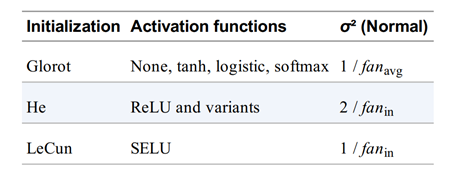

<p>&nbsp;</p>

<p><span style="color:#d35400"><span style="font-size:16px"><strong>Why I Have Used So Much Neurons (800+600+600) ?</strong></span></span></p>

<p><span style="font-size:16px">Vincent Vanhoucke, a scientist at Google, has dubbed this the <strong>&ldquo;stretch pants&rdquo; </strong>approach: instead of wasting time looking for pants that perfectly match your size, just use large stretch pants that will shrink down to the right size. With this approach, you avoid <em><strong>bottleneck </strong></em>layers that could ruin your model. On the flip side, <em>if a layer has too few neurons, it will not have enough representational power to preserve all the useful information from the inputs (e.g., a layer with two neurons can only output 2D data, so if it processes 3D data, some information will be lost). No matter how big and powerful the rest of the network is, that information will never be recovered</em>.</span></p>

<p><span style="font-size:16px">So, in my opinion,<em><strong> if the latency of the final model is not a huge problem for us, using more neurons than we need is usually better for accuracy.</strong> </em><strong>Plus, it will probably not affect the training time! </strong>Because, despite each epoch time will slow down with more neurons, the model will reach the optima with fewer epochs. Eventually, total training time will probably not change significantly.</span></p>

<p>&nbsp;</p>


In [66]:
keras.backend.clear_session()
tf.random.set_seed(44)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28,28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(800, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(600, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(600, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense (Dense)                (None, 800)               628000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 800)               3200      
_________________________________________________________________
dropout (Dropout)            (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 600)               480600    
_________________________________________________________________
batch_normalization_2 (Batch (None, 600)               2

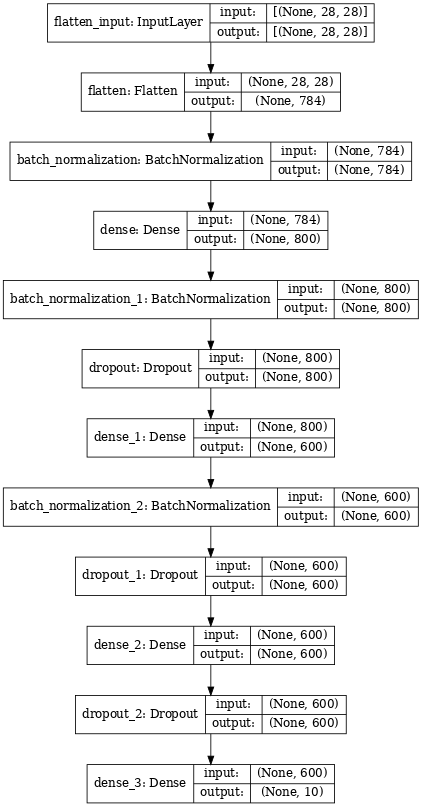

In [68]:
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True, dpi=60)

# Optimizers

<p><span style="font-size:16px">Classical optimizers like gradient descent or stochastic gradient descent (SGD) are very powerful techniques. Nevertheless, they are very old and more powerful techniques are being invented by the time. In the list below, I have created 4 optimizers as <em>&quot;<strong>sgd</strong>&quot;, &quot;<strong>adam</strong>&quot;, &quot;<strong>nadam</strong>&quot; and &quot;<strong>rmsprop</strong>&quot;</em>. But before them, it is better to learn some concepts like <em>momentum optimization</em>, <em>nesterov accelerated gradient.</em></span></p>

<p><span style="font-size:16px"><em>Here is a YouTube video from Andrew NG that explains momentum optimization:</em></span></p>
<p>&nbsp;</p>


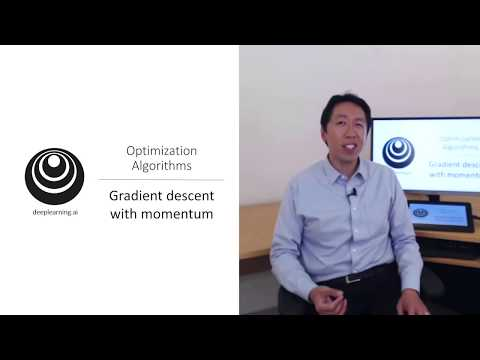

In [69]:
from IPython.display import YouTubeVideo

YouTubeVideo('k8fTYJPd3_I', width=800, height=300)

<h1><span style="font-size:16px">In my experiment, I have seen that &quot;<strong>adam</strong>&quot; performed better than the others. </span></h1>

<h1><span style="font-size:16px">The<em> &#39;beta_1&#39;&nbsp; </em>argument in the optimizer refers to Momentum decay hyperparameter.</span></h1>

<p><span style="font-size:16px">The<em> &#39;beta_2&#39;</em> argument refers to Scaling decay hyperparameter.</span></p>

<p>&nbsp;</p>

<p><span style="font-size:14.9925pt"><span style="font-family:Arial-BoldMT"><span data-darkreader-inline-color="" style="--darkreader-inline-color:#ce7d7d; color:#c67171"><strong>WARNING </strong></span></span></span></p>

<p><span style="font-size:16px">Adaptive optimization methods (including RMSProp, Adam, and Nadam optimization) are often great, converging fast to a good solution. However, a 2017 paper by Ashia C. Wilson et al. showed that they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model&rsquo;s performance, try using plain Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients. Also check out the latest research, because it&rsquo;s moving fast.</span></p>

<p style="text-align:right">Aurelion Geron&nbsp;~ Hands on Machine Learning with Scikit Keras and Tensorflow (2019)</p>

In [70]:
opt_list = {
    "sgd": tf.keras.optimizers.SGD(learning_rate=0.01,
                            momentum=0.95,
                            nesterov=True),
    "adam": tf.keras.optimizers.Adam(learning_rate=0.01,
                            beta_1=0.9,
                            beta_2=0.999),
    "nadam": tf.keras.optimizers.Nadam(learning_rate=0.01,
                              beta_1=0.9,
                              beta_2=0.999,
                              epsilon=1e-07),
    "rmsprop":tf.keras.optimizers.RMSprop(learning_rate=0.01,
                                rho=0.9),
           }

# Callbacks

<h3>These are the callbacks that I&#39;ve used in my model:</h3>

<ul>
	<li><span style="font-size:16px">ReduceLROnPlateau</span></li>
	<li><span style="font-size:16px">Checkpoints (my <strong>original </strong>functions to save the models with best val_accuracy and val_loss. and evaluate them)</span></li>
	<li><span style="font-size:16px">Plot Losses (a library that I&#39;ve edited to plot accuracy and loss during training time.)</span></li>
</ul>

<p><strong><span style="font-size:16px">a. ReduceLROnPlateau</span></strong></p>

<p><span style="font-size:16px">If the <strong>val_loss </strong>value of a model does not improve by <strong>30 epochs</strong>, multiply the <strong>learning_rate </strong>by<strong> 0.5</strong>.</span></p>

<p><span style="font-size:16px"><strong>b. Checkpoints</strong></span></p>

<p><strong>You can see the function in this link:&nbsp;<a href="https://github.com/shiny-apricot/My-Machine-Learning-Works/blob/372cfa4421638bbe3b4bf9044cea348dafe7defa/My_Library/tf_checkpoint.py">shiny-apricot/tf_checkpoint.py</a></strong></p>

<p><span style="font-size:16px"><strong>c. Plot Accuracy-Loss During Training Phase</strong></span></p>

<p><strong>You can see the function in this link:&nbsp;<a href="https://github.com/shiny-apricot/My-Machine-Learning-Works/blob/372cfa4421638bbe3b4bf9044cea348dafe7defa/My_Library/tf_model_plot_loss.py">shiny-apricot/tf_plot_loss.py</a></strong></p>

<p>&nbsp;</p>


### Reduce LR
<p><span style="font-size:18px"><strong>If &#39;val_loss&#39; does not improve for &#39;30&#39; epochs, then multiply the current learning rate by &#39;0.5&#39;.</strong></span></p>



In [71]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                              patience=30, min_lr=0.0001)

#### Checkpoint Generator

<p><strong>You can see the function in this link:&nbsp;<a href="https://github.com/shiny-apricot/My-Machine-Learning-Works/blob/372cfa4421638bbe3b4bf9044cea348dafe7defa/My_Library/tf_checkpoint.py">shiny-apricot/tf_checkpoint.py</a></strong></p>

#### Plot Losses

<p><strong>You can see the function in this link:&nbsp;<a href="https://github.com/shiny-apricot/My-Machine-Learning-Works/blob/372cfa4421638bbe3b4bf9044cea348dafe7defa/My_Library/tf_model_plot_loss.py">shiny-apricot/tf_plot_loss.py</a></strong></p>


In [74]:
cp_val_accuracy, cp_val_loss = checkpoint_generator('mnist')

model.compile(loss="sparse_categorical_crossentropy",
              optimizer= opt_list["adam"], # You can view the opt_list above.
              metrics=["accuracy"],)

<p><span style="font-size:18px">Since the first epochs start with huge loss numbers, it may disrupt our plot image that we will create simultaneously. So, we will train the first 10 epochs seperately.</span></p>


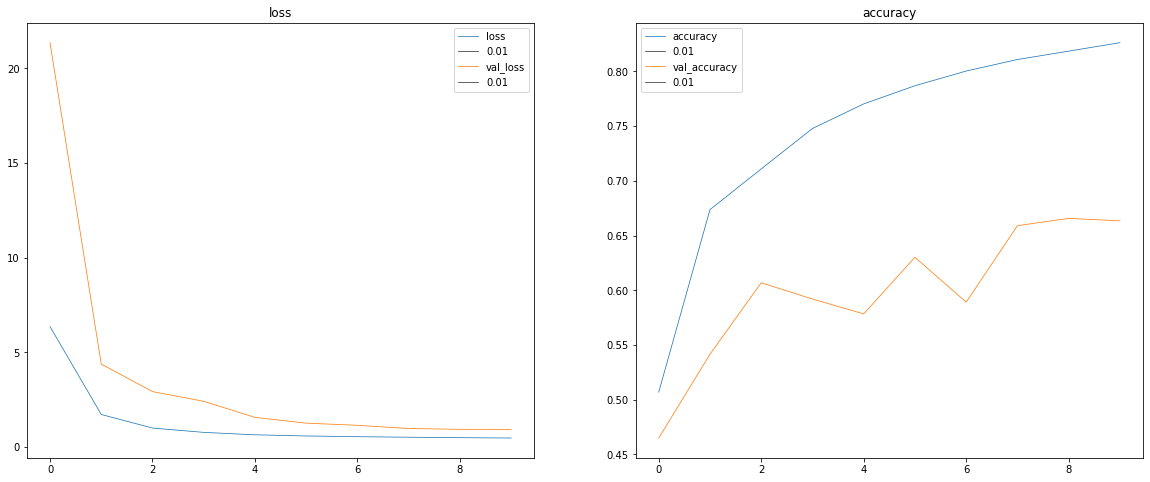

ACCURACY= 0.8262
VAL_ACCURACY= 0.6634
LOSS= 0.477
VAL_LOSS= 0.9337


In [75]:
plot_losses = PlotLosses()

history = model.fit(train_set,
          epochs=10,
          validation_data=valid_set,
          callbacks=[plot_losses,
                     reduce_lr,
                     # These callbacks save the model with the best val_accuracy,
                     cp_val_accuracy, 
                     cp_val_loss,])  # and the model with the best val_loss...

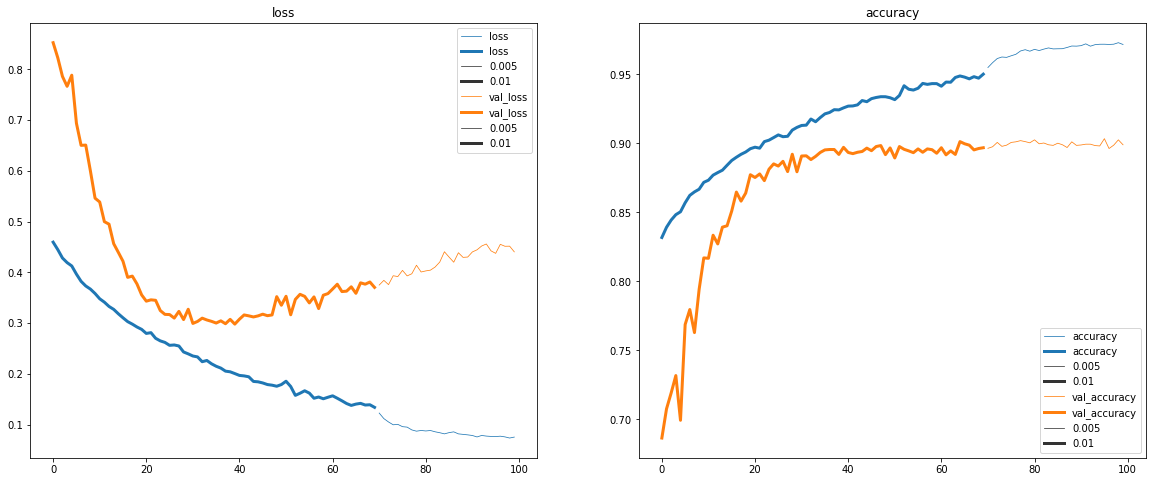

ACCURACY= 0.9717
VAL_ACCURACY= 0.899
LOSS= 0.0758
VAL_LOSS= 0.4405


In [76]:
history = model.fit(train_set,
          epochs=100,
          validation_data=valid_set,
          callbacks=[plot_losses,
                     reduce_lr,
                     # I have added 2 additional callbacks
                     cp_val_accuracy, # These callbacks hold the model with the best val_accuracy,
                     cp_val_loss,])     # and the model with the best val_loss...

<p><span style="font-size:18px">You can clearly see the decrease of the thickness of the line at the end of the image. It refers to the decrease of the learning rate which we have specified with our &quot;ReduceLROnPlateou&quot; Callback.&nbsp;</span></p>


# TESTING

<p><span style="font-size:18px">Let&#39;s test our saved models with the test set using my own function.</span></p>


In [77]:
checkpoint_evaluate('mnist', x=test_set)

mnist_valacc.h5
3/3 [==============================] - 1s 83ms/step - loss: 0.4294 - accuracy: 0.9041

mnist_valloss.h5
3/3 [==============================] - 1s 80ms/step - loss: 0.3021 - accuracy: 0.8972



[[0.42942124605178833, 0.9041000008583069],
 [0.3020588457584381, 0.8971999883651733]]

<p><span style="font-size:20px"><strong>90.41% ACCURACY. THAT IS GREAT FOR A DNN !!</strong></span></p>

<p><span style="font-size:16px">To dispel the doubts, let&#39;s try this with the model in our RAM::</span></p>


In [79]:
model.evaluate(test_set)

3/3 [==============================] - 1s 77ms/step - loss: 0.4344 - accuracy: 0.9041


[0.43441328406333923, 0.9041000008583069]

<p style="text-align:right"><strong><span style="font-size:20px">~yasin inal</span></strong></p>

<p><span style="font-size:20px">My GitHub Page:&nbsp;<a href="https://github.com/shiny-apricot">github.com/shiny-apricot</a></span></p>

<p><span style="font-size:20px">My LinkedIn Profile:&nbsp;</span><span style="font-size:16px"><a href="https://www.linkedin.com/in/yasin-inal-abb41876/">Yasin Inal | LinkedIn</a></span></p>
